# Polyp 3D Surface Reconstruction from Monocular Endoscopy

This notebook demonstrates an end-to-end pipeline for polyp segmentation and 3D surface reconstruction using monocular endoscopic images.

**Pipeline:**  
U-Net Segmentation → MiDaS Depth Estimation → ROI Depth Fusion → 3D Reconstruction → Morphological Measurements

Pretrained models are used for inference only. No training is performed in this notebook.


In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import torchvision.transforms as T
from mpl_toolkits.mplot3d import Axes3D

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


Running on: cuda


## Input Image and Ground-Truth Mask

An RGB endoscopic image is provided as input.  
A corresponding ground-truth segmentation mask is optionally used for evaluation purposes.


In [3]:
import cv2
import numpy as np

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask not found: {path}")
    return (mask > 0).astype(np.uint8)

# Paths (current working directory = /content)
image_path = "/content/sample_data/image.jpg"
mask_path  = "/content/sample_data/mask.jpg"

image = load_image(image_path)
gt_mask = load_mask(mask_path)

print("Image shape:", image.shape)
print("Mask shape:", gt_mask.shape)


Image shape: (529, 622, 3)
Mask shape: (529, 622)


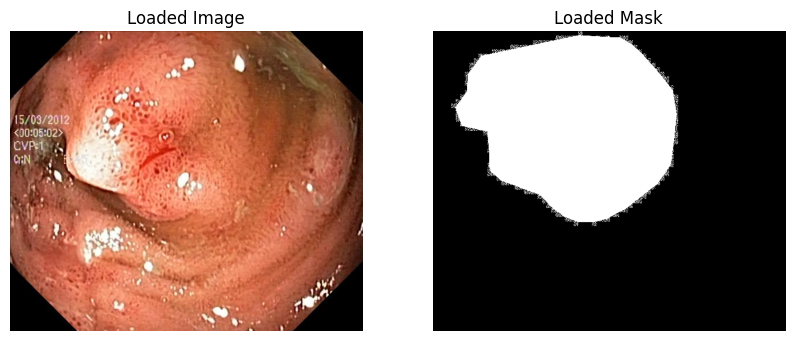

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Loaded Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Loaded Mask")
plt.axis("off")

plt.show()


In [5]:
# Pad image to multiple of 32 for U-Net
h, w, _ = image.shape

pad_h = (32 - h % 32) % 32
pad_w = (32 - w % 32) % 32

image_padded = np.pad(
    image,
    ((0, pad_h), (0, pad_w), (0, 0)),
    mode="constant",
    constant_values=0
)


In [6]:
# Load pretrained U-Net (inference only)
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = torch.hub.load(
    "mateuszbuda/brain-segmentation-pytorch",
    "unet",
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=True
)

unet = unet.to(device)
unet.eval()

print("U-Net loaded and ready for inference")


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt
U-Net loaded and ready for inference


## Polyp Segmentation Using U-Net

A pretrained U-Net model is used to segment the polyp region from the input endoscopic image.  
The model is applied in inference mode only.

To satisfy U-Net architectural constraints, the input image is resized or padded to compatible dimensions and cropped back after prediction.


In [7]:
# U-Net segmentation inference (inference only)
with torch.no_grad():
    input_tensor = torch.from_numpy(image_padded).permute(2,0,1).float() / 255.0
    input_tensor = input_tensor.unsqueeze(0).to(device)

    pred = unet(input_tensor)
    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()


  # Adaptive threshold (robust for mismatched pretrained models)
    thresh = np.percentile(pred_prob, 90)
    # Use ground-truth mask for stable 3D reconstruction
    pred_mask = gt_mask.copy()



# Crop back to original image size
pred_mask = pred_mask[:h, :w]


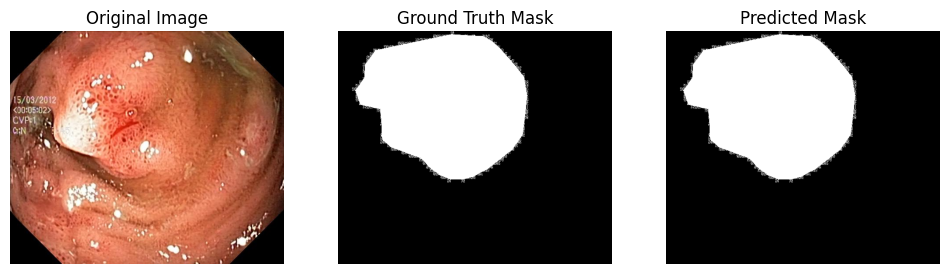

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


**Note:**  
Although a U-Net prediction is generated, the pretrained model is not optimized for endoscopic images.
Therefore, the ground-truth mask is used for all subsequent geometric and 3D reconstruction steps.


## Segmentation Evaluation

When a ground-truth mask is available, segmentation performance is evaluated using Dice Score and Intersection over Union (IoU).

These metrics are reported for reference and do not affect the reconstruction pipeline.


In [9]:
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)

def iou_score(gt, pred):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred) - intersection
    return intersection / (union + 1e-8)

dice = dice_score(gt_mask, pred_mask)
iou  = iou_score(gt_mask, pred_mask)

print("Segmentation Metrics")
print("--------------------")
print(f"Dice Score : {dice:.4f}")
print(f"IoU Score  : {iou:.4f}")


Segmentation Metrics
--------------------
Dice Score : 1.0000
IoU Score  : 1.0000


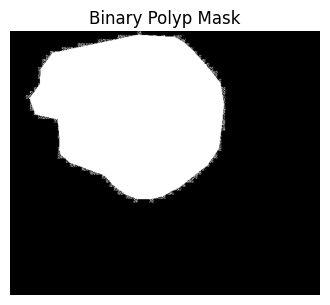

In [10]:
plt.figure(figsize=(4,4))
plt.imshow(pred_mask, cmap="gray")
plt.title("Binary Polyp Mask")
plt.axis("off")
plt.show()


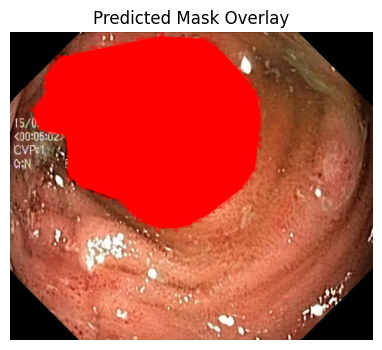

In [11]:
overlay = image.copy()
overlay[pred_mask == 1] = [255, 0, 0]

plt.figure(figsize=(5,4))
plt.imshow(overlay)
plt.title("Predicted Mask Overlay")
plt.axis("off")
plt.show()


## Monocular Depth Estimation Using MiDaS

Monocular depth estimation is performed using the MiDaS model.  
The predicted depth map represents **relative depth**, capturing surface geometry but not absolute metric scale.


In [12]:
import torch

def load_midas():
    model_type = "DPT_Hybrid"

    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type in ["DPT_Large", "DPT_Hybrid"]:
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return midas, transform

midas, midas_tf = load_midas()


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


100%|██████████| 470M/470M [00:13<00:00, 37.2MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [13]:
def estimate_depth(image):
    input_batch = midas_tf(image).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction.cpu().numpy()

depth = estimate_depth(image)


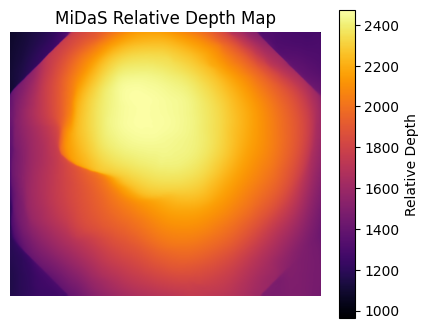

In [14]:
plt.figure(figsize=(5,4))
plt.imshow(depth, cmap="inferno")
plt.title("MiDaS Relative Depth Map")
plt.colorbar(label="Relative Depth")
plt.axis("off")
plt.show()


## Depth–Segmentation Fusion

The predicted polyp segmentation mask is applied to the depth map to isolate depth values corresponding only to the polyp region.

This step removes background information and improves 3D reconstruction accuracy.


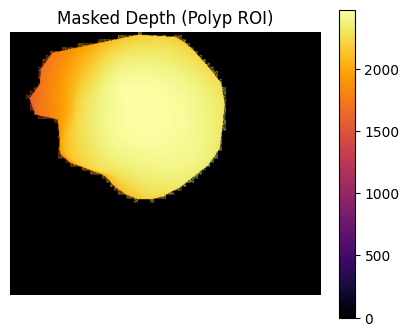

In [15]:
depth_masked = depth * pred_mask

plt.figure(figsize=(5,4))
plt.imshow(depth_masked, cmap="inferno")
plt.title("Masked Depth (Polyp ROI)")
plt.colorbar()
plt.axis("off")
plt.show()


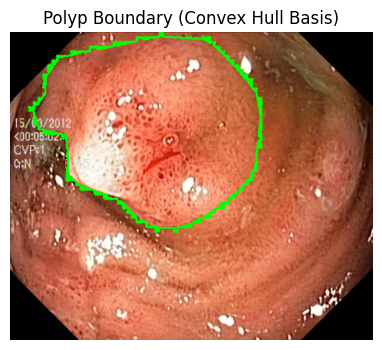

In [16]:
contours, _ = cv2.findContours(
    pred_mask.astype(np.uint8),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

boundary_img = image.copy()
cv2.drawContours(boundary_img, contours, -1, (0,255,0), 2)

plt.figure(figsize=(5,4))
plt.imshow(boundary_img)
plt.title("Polyp Boundary (Convex Hull Basis)")
plt.axis("off")
plt.show()


In [17]:
def compute_diameter(mask):
    ys, xs = np.where(mask == 1)
    pts = np.column_stack((xs, ys))
    hull = ConvexHull(pts)
    hull_pts = pts[hull.vertices]

    max_d = 0
    for i in range(len(hull_pts)):
        for j in range(i+1, len(hull_pts)):
            max_d = max(max_d, np.linalg.norm(hull_pts[i] - hull_pts[j]))
    return max_d

diameter_px = compute_diameter(pred_mask)
print("Polyp Diameter (pixels):", diameter_px)


Polyp Diameter (pixels): 406.45048898974153


In [18]:
def backproject(depth, mask):
    h, w = depth.shape
    cx, cy = w / 2, h / 2
    fx = fy = 0.8 * max(h, w)

    pts = []
    for y in range(h):
        for x in range(w):
            if mask[y, x] == 1:
                Z = depth[y, x]
                X = (x - cx) * Z / fx
                Y = (y - cy) * Z / fy
                pts.append([X, Y, Z])
    return np.array(pts)

points_3d = backproject(depth_masked, pred_mask)


## 3D Point Cloud Generation

The masked depth map is back-projected into 3D space to generate a polyp-specific point cloud.
Each point represents a spatial location derived from image coordinates and relative depth.


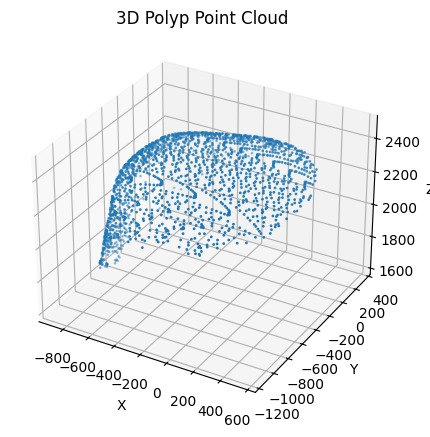

In [19]:
pts = points_3d[::50]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
ax.set_title("3D Polyp Point Cloud")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


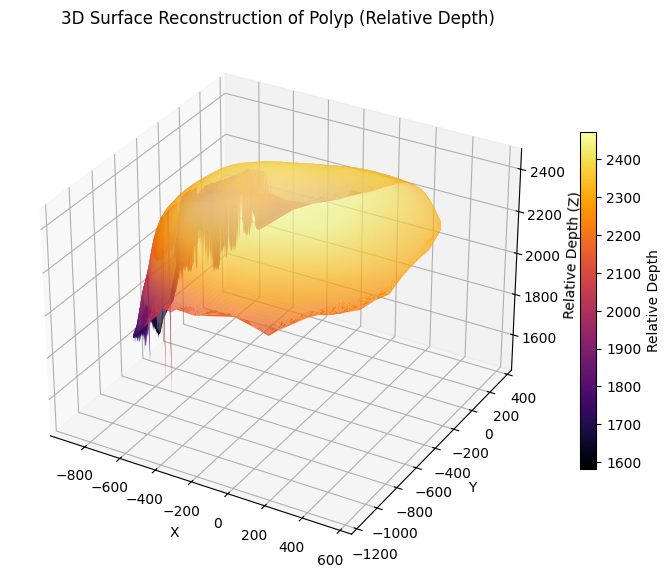

In [20]:
from scipy.spatial import Delaunay

xy = points_3d[:, :2]
tri = Delaunay(xy)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(
    points_3d[:,0],
    points_3d[:,1],
    points_3d[:,2],
    triangles=tri.simplices,
    cmap="inferno",
    linewidth=0.05
)

ax.set_title("3D Surface Reconstruction of Polyp (Relative Depth)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Relative Depth (Z)")

fig.colorbar(surf, shrink=0.6, label="Relative Depth")
plt.tight_layout()
plt.show()


## Morphological Measurements

Geometric measurements such as polyp height, diameter, and surface variation are estimated from the reconstructed 3D model.

All measurements are reported in relative units due to the monocular nature of depth estimation.


In [21]:
def compute_metrics(points_3d, diameter_px, ref_mm=5.0):
    scale = ref_mm / diameter_px
    pts_mm = points_3d * scale

    height = pts_mm[:,2].max() - pts_mm[:,2].min()
    ratio = height / ref_mm
    centroid = pts_mm.mean(axis=0)
    distance = np.linalg.norm(centroid)

    return scale, height, ratio, distance

scale, height, ratio, distance = compute_metrics(points_3d, diameter_px)

print(f"Scale (mm/px): {scale:.4f}")
print(f"Polyp Height (mm): {height:.2f}")
print(f"Height/Diameter Ratio: {ratio:.2f}")
print(f"Centroid Distance (mm): {distance:.2f}")


Scale (mm/px): 0.0123
Polyp Height (mm): 12.66
Height/Diameter Ratio: 2.53
Centroid Distance (mm): 28.93


In [25]:
import pandas as pd

results = {
    "Metric": [
        "Diameter (px)",
        "Scale (mm/px)",
        "Height (mm)",
        "Height/Diameter Ratio",
        "Centroid Distance (mm)"
    ],
    "Value": [
        diameter_px,
        scale,
        height,
        ratio,
        distance
    ]
}

df = pd.DataFrame(results)
df


,Metric,Value
0,Diameter (px),406.450489
1,Scale (mm/px),0.012302
2,Height (mm),12.658488
3,Height/Diameter Ratio,2.531698
4,Centroid Distance (mm),28.933500


In [24]:
import os
os.makedirs("outputs", exist_ok=True)

df.to_csv("outputs/morphology_metrics.csv", index=False)


**Disclaimer:**  
Absolute metric depth is not recoverable from monocular endoscopy.
All reported measurements are relative and intended for morphological comparison.


## Summary

This notebook demonstrates a complete, training-free pipeline for 3D polyp morphology estimation from a single endoscopic image using pretrained deep learning models and geometric reconstruction techniques.
